In [1]:
import os
import sys
import pickle
import argparse
import numpy as np
import copy

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector
from torch.utils.data import DataLoader
from torch.func import jacrev, vmap
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import accuracy_score

from ivon import IVON

In [2]:
%matplotlib ipympl
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
class LeNet5(nn.Module):
    def __init__(self, output_size=10):
        super().__init__()
        self.output_size = output_size

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.act3 = nn.Tanh()

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(1 * 1 * 120, 84)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.act3(self.conv3(x))
        x = self.act4(self.fc1(self.flat(x)))
        x = self.fc2(x)
        return x

def get_dataset_mnist():
    transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])
    ds_train = torchvision.datasets.MNIST(
    root='../data', train=True, download=True, transform=transform_mnist)
    ds_test = torchvision.datasets.MNIST(
    root='../data', train=False, download=True, transform=transform_mnist)
    return ds_train, ds_test

def train_one_epoch_ivon(net, optim):
    net.train()
    running_loss = 0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        with optim.sampled_params(train=True):
            optim.zero_grad()
            fs = net(X)
            loss = criterion(fs, y)
            loss.backward()
        optim.step()
        running_loss += loss.item()
    scheduler.step()
    return net, optim

def get_covariance_from_ivon(optim):
    sigma_sqrs = []
    offset = 0
    for group in optim.param_groups:
        std = 1 / (group["ess"] * (group["hess"] + group["weight_decay"])).sqrt()
        goffset = 0
        for p in group['params']:
            if p.requires_grad:
                if p is None:
                    continue
                numel = p.numel()
                std_ = std[offset: offset + numel]
                sigma_sqrs.append((std_**2).tolist())
                goffset += numel
                offset += numel
        assert goffset == group["numel"]
    return sigma_sqrs

def get_prediction_vars(optim):
    sigma_sqrs = get_covariance_from_ivon(optim)
    sigma_sqrs = torch.asarray(flatten(sigma_sqrs)).to(device)
    vars = get_pred_vars_optim(net, trainloader_vars, sigma_sqrs, device)
    return vars, optim

def get_pred_vars_optim(model, loader, sigma_diag, device='cuda'):
    fvars = []
    fnet, params = make_functional(model, disable_autograd_tracking=True)

    def fnet_single(params, x):
        f = fnet(params, x.unsqueeze(0)).squeeze(0)
        return (f, f)

    for X, y in loader:
        X, y = X.to(device), y.to(device)

        Js, f = vmap(jacrev(fnet_single, has_aux=True), (None, 0))(params, X)
        Js = torch.cat([j.flatten(2) for j in Js], dim=2)
        fvar = torch.einsum('nkp,p,ncp->nkc', Js, sigma_diag, Js)
        fvars.append(fvar)

    fvars = torch.squeeze(torch.cat(fvars)).cpu().detach()
    return fvars

def make_functional(mod, disable_autograd_tracking=False):
    params_dict = dict(mod.named_parameters())
    params_names = params_dict.keys()
    params_values = tuple(params_dict.values())

    stateless_mod = copy.deepcopy(mod)
    stateless_mod.to('meta')

    def fmodel(new_params_values, *args, **kwargs):
        new_params_dict = {name: value for name, value in zip(params_names, new_params_values)}
        return torch.func.functional_call(stateless_mod, new_params_dict, args, kwargs)

    if disable_autograd_tracking:
        params_values = torch.utils._pytree.tree_map(torch.Tensor.detach, params_values)
    return fmodel, params_values


def get_estimated_nll(nc, residuals, vars, logits, all_targets, eps=1e-10):
    sensitivities = residuals * vars
    logits_perturbed = sensitivities + logits
    probs_perturbed = torch.softmax(logits_perturbed, dim=-1)

    nll = - torch.sum((torch.log(probs_perturbed.clamp(min=eps)) * F.one_hot(all_targets, nc)),dim=1).mean().numpy()
    return nll

def predict(net, loader, nc, all_targets, device='cuda', eps=1e-10, train=True):
    with torch.no_grad():
        net.eval()

        preds_list = []
        res_list, logits_list, probs_list, nll_hess_list = [], [], [], []
        for X, y in loader:
            X, y = X.to(device), y.to(device)

            logits = net.forward(X)
            probs = F.softmax(logits, dim=-1)
            _, preds = probs.max(1)

            preds_list.append(preds.cpu().detach())
            probs_list.append(probs.cpu().detach())
            if train:
                residuals = probs - F.one_hot(y, nc)
                res_list.append(residuals.cpu().detach())
                logits_list.append(logits.cpu().detach())
                nll_hess = torch.diag_embed(probs) - torch.einsum('ij,ik->ijk', probs, probs)
                nll_hess_list.append(nll_hess.cpu().detach())

        probs_list = torch.vstack(probs_list)
        acc = accuracy_score(all_targets, torch.cat(preds_list).numpy())
        nll = - torch.sum((torch.log(torch.clamp(probs_list, eps, 1-eps)) * F.one_hot(all_targets, nc)),dim=1).mean().numpy()

        if train:
            return torch.vstack(res_list), torch.vstack(logits_list), torch.vstack(nll_hess_list), acc, nll
        else:
          return acc, nll

def flatten(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


In [4]:
# MNIST
ds_train, ds_test = get_dataset_mnist()

lr = 0.2
bs = 256
bs_jacs = 500
delta = 60
hess_init = 0.1
epochs = 10 #100

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

device = 'cuda'

input_size = len(ds_train.data[0, :])**2
nc = max(ds_train.targets) + 1
n_train = len(ds_train)
tr_targets, te_targets = torch.asarray(ds_train.targets), torch.asarray(ds_test.targets)

# Loss
criterion = nn.CrossEntropyLoss(reduction='mean')

# Dataloaders
trainloader = DataLoader(ds_train, batch_size=bs) # training
trainloader_eval = DataLoader(ds_train, batch_size=bs, shuffle=False) # train evaluation
testloader_eval = DataLoader(ds_test, batch_size=bs, shuffle=False) # test evaluation
trainloader_vars = DataLoader(ds_train, batch_size=bs_jacs, shuffle=False) # variance computation

# Model
net = LeNet5(output_size=nc).to(device)

# Optimizer
optim = IVON(net.parameters(), lr=lr, mc_samples=1, ess=n_train, weight_decay=delta/n_train,
              beta1=0.9, beta2=0.99999, hess_init=hess_init)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs, eta_min=0)


In [5]:
def display_immediately(fig):
    canvas = fig.canvas
    display(canvas)
    canvas._handle_message(canvas, {'type': 'send_image_mode'}, [])
    canvas._handle_message(canvas, {'type':'refresh'}, [])
    canvas._handle_message(canvas,{'type': 'initialized'},[])
    canvas._handle_message(canvas,{'type': 'draw'},[])


In [6]:
# figure must be instantiated in different cell to plotting code (otherwise bug)
plt.close('all')
with plt.ioff():
    fig = plt.figure(figsize=(7,7), constrained_layout=True)

In [7]:
def get_indices_class_based(scores, n_classes=10):
    indices = []
    for cc in np.arange(n_classes):
        ii_class = np.where(tr_targets.numpy()==cc)[0]
        indices.append(ii_class[np.argmax(scores[ii_class])])
    return indices

def get_indices_show(levscores, residuals):
    levscores_norm = (levscores - np.min(levscores))/(np.max(levscores)-np.min(levscores))
    residuals_norm = (residuals-np.min(residuals))/(np.max(residuals)-np.min(residuals))

    scores_proto = (1.-levscores_norm) + (1.-residuals_norm)
    scores_outlier = (1.-levscores_norm) + residuals_norm
    scores_uncertain = levscores_norm + (1.-residuals_norm)
    scores_influence = levscores_norm + residuals_norm

    # # class-based 
    # indices_proto = get_indices_class_based(scores_proto)
    # indices_outlier = get_indices_class_based(scores_outlier)
    # indices_uncertain = get_indices_class_based(scores_uncertain)

    indices_proto = np.argsort(scores_proto)[::-1][:10]
    indices_outlier = np.argsort(scores_outlier)[::-1][:10]
    indices_uncertain = np.argsort(scores_uncertain)[::-1][:10]
    indices_influence = np.argsort(scores_influence)[::-1][:10]

    return indices_proto, indices_outlier, indices_uncertain, indices_influence

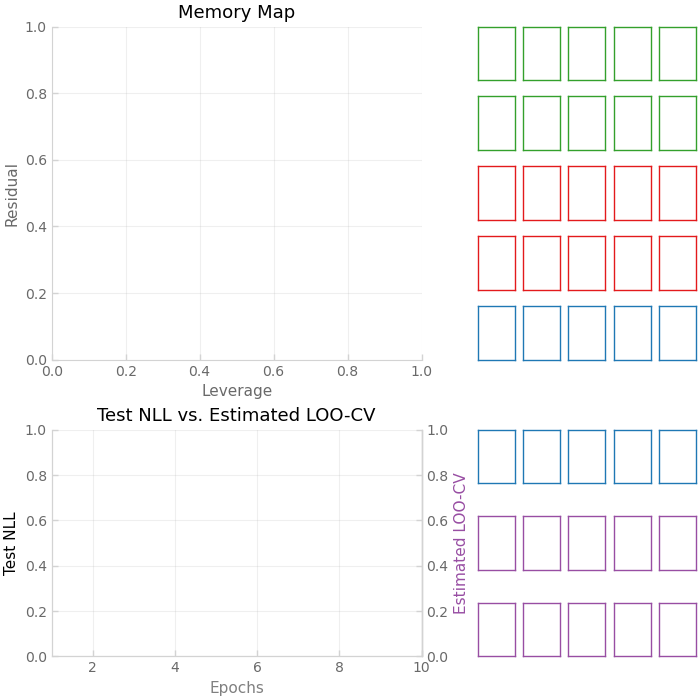

Epoch 1
-------------------------------
Test Acc: 93.39%, Test NLL: 0.220330
Train Acc: 93.08%, Train NLL: 0.232569
Epoch 2
-------------------------------
Test Acc: 96.22%, Test NLL: 0.122705
Train Acc: 96.05%, Train NLL: 0.133418
Epoch 3
-------------------------------
Test Acc: 97.25%, Test NLL: 0.089701
Train Acc: 97.11%, Train NLL: 0.098291
Epoch 4
-------------------------------
Test Acc: 97.72%, Test NLL: 0.073889
Train Acc: 97.63%, Train NLL: 0.081049
Epoch 5
-------------------------------
Test Acc: 97.98%, Test NLL: 0.065795
Train Acc: 97.99%, Train NLL: 0.070550
Epoch 6
-------------------------------
Test Acc: 98.07%, Test NLL: 0.060627
Train Acc: 98.15%, Train NLL: 0.064675
Epoch 7
-------------------------------
Test Acc: 98.29%, Test NLL: 0.056622
Train Acc: 98.32%, Train NLL: 0.060469
Epoch 8
-------------------------------
Test Acc: 98.41%, Test NLL: 0.052170
Train Acc: 98.47%, Train NLL: 0.054896
Epoch 9
-------------------------------
Test Acc: 98.47%, Test NLL: 0.05

In [8]:
#### Setup plot ####
gs = fig.add_gridspec(8, 15)
ax_mm = fig.add_subplot(gs[:5, :10])
ax_nll = fig.add_subplot(gs[5:, :10])

n_classes = nc.item() #10
axs_proto, axs_outlier, axs_uncertain, axs_influence = [], [], [], []
for ii in range(10):
    axs_proto.append(fig.add_subplot(gs[ii // (n_classes//2), 10+(ii % (n_classes//2))]))
    axs_outlier.append(fig.add_subplot(gs[2+(ii // (n_classes//2)), 10+(ii % (n_classes//2))]))
    axs_uncertain.append(fig.add_subplot(gs[4+(ii // (n_classes//2)), 10+(ii % (n_classes//2))]))
    axs_influence.append(fig.add_subplot(gs[6+(ii // (n_classes//2)), 10+(ii % (n_classes//2))]))

ax_mm.set_title('Memory Map', fontsize=13)
ax_nll.set_title('Test NLL vs. Estimated LOO-CV', fontsize=13)

ax_mm.set_xlim(0)
ax_mm.set_ylim(0)
ax_mm.spines['right'].set_visible(False)
ax_mm.spines['top'].set_visible(False)
ax_mm.spines['bottom'].set_color('lightgray')
ax_mm.spines['left'].set_color('lightgray')
ax_mm.grid(True, alpha=0.2)
ax_mm.tick_params(direction='in', labelsize=10, length=4., width=1, color='lightgray')
ax_mm.set_xlabel('Leverage', fontsize=11, color='dimgray')
ax_mm.set_ylabel('Residual', fontsize=11, color='dimgray')
[t.set_color('dimgray') for t in ax_mm.xaxis.get_ticklabels()]
[t.set_color('dimgray') for t in ax_mm.yaxis.get_ticklabels()]

ax_nll.set_xlabel('Epochs', fontsize=11, color='0.5')
ax_nll.set_ylabel('Test NLL', fontsize=11, color='k')
ax_nll.set_xlim(1,epochs)
ax_nll.spines['top'].set_visible(False)
ax_nll.spines['left'].set_color('lightgray')
ax_nll.spines['bottom'].set_color('lightgray')
ax_nll.grid(True, alpha=0.2)
ax_nll.tick_params(axis='y', direction='in', labelsize=10, length=4., width=1, color='lightgray')
ax_nll.tick_params(axis='x', direction='in', labelsize=10, length=4., width=1, color='lightgray')
[t.set_color('dimgray') for t in ax_nll.xaxis.get_ticklabels()]
[t.set_color('dimgray') for t in ax_nll.yaxis.get_ticklabels()]

col_influence = mpl.colormaps['Set1'](3)
ax_nll_2 = ax_nll.twinx()
ax_nll_2.spines['top'].set_visible(False)
ax_nll_2.spines['left'].set_color('lightgray')
ax_nll_2.spines['right'].set_color('lightgray')
ax_nll_2.spines['bottom'].set_color('lightgray')
ax_nll_2.set_ylabel('Estimated LOO-CV', fontsize=11, color=col_influence)
ax_nll_2.tick_params(axis='y', direction='in', labelsize=10, length=4., width=1, color='lightgray')
[t.set_color('dimgray') for t in ax_nll_2.yaxis.get_ticklabels()]

col_uncertain = mpl.colormaps['Paired'](1) # dark blue
col_easy = mpl.colormaps['Paired'](3) #green
col_outlier = mpl.colormaps['Paired'](5) #red

for axs, col in zip([axs_proto, axs_outlier, axs_uncertain, axs_influence], [col_easy,col_outlier,col_uncertain,col_influence]):
    for ax in axs:
        ax.tick_params(bottom=False, top=False, left=False, right=False)
        ax.tick_params(labelbottom=False, labelleft=False)
        for spine in ax.spines.values():
            spine.set_color(col)
        [x.set_linewidth(1) for x in ax.spines.values()]

display_immediately(fig)

residual_upper, leverage_upper = 0.,0.
test_nll_lst, loocv_lst = [], []
mpl_lines = []
im_lst = [[None for _ in range(len(axs_proto))] for _ in range(4)]
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    # Train for one epoch
    net, optim = train_one_epoch_ivon(net, optim)

    # Evaluate on test data
    test_acc, test_nll = predict(net, testloader_eval, nc, te_targets, device, train=False)
    print(f"Test Acc: {(100 * test_acc):>0.2f}%, Test NLL: {test_nll:>6f}")
    test_nll_lst.append(test_nll)
    
    # Evaluate on training data; residuals and logits
    # residuals & nll_hess evaluated at mean here
    residuals, logits, nll_hess, train_acc, train_nll = predict(net, trainloader_eval, nc, tr_targets, device)
    print(f"Train Acc: {(100 * train_acc):>0.2f}%, Train NLL: {train_nll:>6f}")

    # Prediction variances
    vars, optim = get_prediction_vars(optim) #MOD: returns full (CxC) marginal variances

    # Estimate test-NLL with approximate leave-one-out cross-validation
    vars_diag = vars.diagonal(dim1=1, dim2=2) #MOD
    estimated_nll = get_estimated_nll(nc, residuals, vars_diag, logits, tr_targets)
    loocv_lst.append(estimated_nll)

    # Evaluate memory map criteria
    residuals_summary = torch.sqrt(torch.sum(residuals**2, dim=1)).detach().numpy() # l2norm
    lev_scores_full = torch.einsum('nij,nji->ni', vars, nll_hess)
    lev_scores_full = torch.clamp(lev_scores_full, 0.)
    lev_scores_summary = torch.sqrt(torch.sum(lev_scores_full**2, dim=1)).cpu().detach().numpy()

    indices_proto, indices_outlier, indices_uncertain, indices_influence = get_indices_show(lev_scores_summary, residuals_summary)

    leverage_upper = lev_scores_summary.max() if lev_scores_summary.max() > leverage_upper else leverage_upper
    residual_upper = residuals_summary.max() if residuals_summary.max() > residual_upper else residual_upper

    # clear axes
    if epoch > 0:
        for ll in mpl_lines:
            ll.remove()
            del ll
        mpl_lines = []
    
    scat = ax_mm.scatter(lev_scores_summary, residuals_summary, color='k', marker='.', s=10, linewidths=0)
    mpl_lines.append(scat)

    # plot emphasised markers on memory map
    for m_x,m_y in zip(lev_scores_summary[indices_proto],residuals_summary[indices_proto]):
        scat = ax_mm.scatter(m_x, m_y, zorder=3, color=col_easy, s=25, marker='o', clip_on=False, ec='k', lw=0.25)
        mpl_lines.append(scat)
    for m_x,m_y in zip(lev_scores_summary[indices_outlier],residuals_summary[indices_outlier]):
        scat = ax_mm.scatter(m_x, m_y, zorder=3, color=col_outlier, s=25, marker='o', clip_on=False, ec='k', lw=0.25)
        mpl_lines.append(scat)
    for m_x,m_y in zip(lev_scores_summary[indices_uncertain],residuals_summary[indices_uncertain]):
        scat = ax_mm.scatter(m_x, m_y, zorder=3, color=col_uncertain, s=25, marker='o', clip_on=False, ec='k', lw=0.25)
        mpl_lines.append(scat)
    for m_x,m_y in zip(lev_scores_summary[indices_influence],residuals_summary[indices_influence]):
        scat = ax_mm.scatter(m_x, m_y, zorder=3, color=col_influence, s=25, marker='o', clip_on=False, ec='k', lw=0.25)
        mpl_lines.append(scat)
    
    ax_mm.set_xlim(0, leverage_upper)
    ax_mm.set_ylim(0, residual_upper)

    # plot NLL curves
    line1 = ax_nll.plot(np.arange(epoch+1)+1, np.array(test_nll_lst), marker='o', color='k', lw=0.5, ms=2.5)
    mpl_lines.append(line1[0])
    line2 = ax_nll_2.plot(np.arange(epoch+1)+1, np.array(loocv_lst), marker='^', color=col_influence, lw=0.5, ms=2.5)
    mpl_lines.append(line2[0])

    # plot digits
    for ii, (axs, indices) in enumerate(zip([axs_proto, axs_outlier, axs_uncertain, axs_influence], [indices_proto, indices_outlier, indices_uncertain, indices_influence])):
        for jj, (ax, img_idx) in enumerate(zip(axs,indices)):
            digit = ds_train.data[img_idx,:,:].numpy()
            label = tr_targets[img_idx].item()
            if epoch==0:
                im_lst[ii][jj] = ax.imshow(digit, cmap='gray_r')
            else:
                im_lst[ii][jj].set_data(digit)
            txt = ax.text(0.01,0.7, label, color='black', transform=ax.transAxes, fontsize=10,
                    bbox=dict(facecolor='white', edgecolor='lightgray', lw=1, boxstyle='square,pad=0.'))
            mpl_lines.append(txt)
    
    fig.canvas.draw()

# plt.close(fig)